**NOTE** You need to attach this notebook to a Databricks cluster with the **xlrd** library [installed](https://docs.databricks.com/libraries.html#workspace-libraries) and [attached](https://docs.databricks.com/libraries.html#install-a-library-on-a-cluster).  (If you are using the standard Databricks runtime, you can install this library using the [dbutils.library.installPyPI()](https://docs.databricks.com/dev-tools/databricks-utils.html#examples) method.)

###Step 1: Load the Data

To demonstrate the RFM segmentation techniques, we'll need access to some customer transaction history. Such a [dataset](http://archive.ics.uci.edu/ml/datasets/Online+Retail) for an anonymous online retailer is available from the UCI Machine Learning Repository.  This dataset is made available as a Microsoft Excel workbook (XLSX).  Having downloaded this XLSX file to our local system, we can load it into our Databricks environment by following the steps provided [here](https://docs.databricks.com/data/tables.html#create-table-ui). Please note when performing the file import, you don't need to select the *Create Table with UI* or the *Create Table in Notebook* options to complete the import process. Also, the name of the XLSX file will be modified upon import as it includes an unsupported space character.  As a result, we will need to programmatically locate the new name for the file assigned by the import process.

Assuming we've uploaded the XLSX to the */FileStore/tables/online_retail/*, we can access it as follows:

In [0]:
%pip install openpyxl

Python interpreter will be restarted.
Collecting openpyxl
 Downloading openpyxl-3.0.7-py2.py3-none-any.whl (243 kB)
Collecting et-xmlfile
 Downloading et_xmlfile-1.0.1.tar.gz (8.4 kB)
Building wheels for collected packages: et-xmlfile
 Building wheel for et-xmlfile (setup.py): started
 Building wheel for et-xmlfile (setup.py): finished with status 'done'
 Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8917 sha256=44a43ac40cc963e894bc50951344f5bc62a4dfe5cf52401dfc5055c52c221eb6
 Stored in directory: /home/root/.cache/pip/wheels/6e/df/38/abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile
Installing collected packages: et-xmlfile, openpyxl
Successfully installed et-xmlfile-1.0.1 openpyxl-3.0.7
Python interpreter will be restarted.

In [0]:
import pandas as pd
import numpy as np


# identify name of xlsx file (which can change when uploaded)
#xlsx_filename = dbutils.fs.ls('file:///dbfs/FileStore/tables/online_retail')[0][0]

# schema of the excel spreadsheet data range
orders_schema = {
  'InvoiceNo':np.str,
  'StockCode':np.str,
  'Description':np.str,
  'Quantity':np.int64,
  'InvoiceDate':np.datetime64,
  'UnitPrice':np.float64,
  'CustomerID':np.str,
  'Country':np.str  
  }

# read spreadsheet to pandas dataframe
# the xlrd library (loaded at the top of this notebook) is required for this step to work 
orders_pd = pd.read_excel(
  "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx", 
  sheet_name='Online Retail',
  header=0, # first row is header
  dtype=orders_schema
  )

# calculate sales amount as quantity * unit price
orders_pd['SalesAmount'] = orders_pd['Quantity'] * orders_pd['UnitPrice']

We can now push our data into Spark DataFrames and temp views to make interactions with the dataset easier.  But why bother moving the data to Spark when it's already loaded into pandas?  

The dataset we are working with here is small.  In the real world, customer transaction histories, especially when viewed at the line item level as is done in this dataset, can be quite large.  In such a scenario, our data would not likely be delivered as an Excel spreadsheet and we'd want to read it directly into a Spark DataFrame so that we can take advantage of the distributed capacity of our cluster.  For this demonstration, using Spark is a bit overkill, but should you wish to apply these techniques to a different enterprise-scale dataset, seeing the techniques implemented this way could be very useful:

In [0]:
# convert pandas DF to Spark DF
orders = spark.createDataFrame(orders_pd)

# present Spark DF as queriable view
orders.createOrReplaceTempView('orders') 

In [0]:
%sql
SELECT *
FROM orders

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01T08:26:00.000+0000,2.55,17850,United Kingdom,15.299999999999999
536365,71053,WHITE METAL LANTERN,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01T08:26:00.000+0000,2.75,17850,United Kingdom,22.0
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01T08:26:00.000+0000,7.65,17850,United Kingdom,15.3
536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01T08:26:00.000+0000,4.25,17850,United Kingdom,25.5
536366,22633,HAND WARMER UNION JACK,6,2010-12-01T08:28:00.000+0000,1.85,17850,United Kingdom,11.100000000000001
536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01T08:28:00.000+0000,1.85,17850,United Kingdom,11.100000000000001
536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01T08:34:00.000+0000,1.69,13047,United Kingdom,54.08


###Step 2: Calculate the RFM Metrics

To perform RFM segmentation, we need to first calculate recency, frequency and monetary value metrics for each customer.  There's a wide variety of ways to do this, but we'll keep it simple calculating recency, frequency and monetary value as follows:<p>

* **R**ecency - Days since the customer last made a purchase
* **F**requency - Number of unique dates on which a purchase is made
* **M**onetary Value - Total sales amount for this period
  
It's important to note that when calculating the recency metric, we need to consider the date on which our dataset terminates.  The last transaction in this dataset occurs on December 09, 2011. We will use that date as our "current" date for calculating the time since each customer's last purchase.
  
With regard to frequency, it's important we also note that we are not simply counting the number of purchases made by a customer.  Instead, we are counting the number of days on which any number of purchases were made.  In other words, if a customer makes multiple purchases on a single day, this will be counted as a single purchase event. This aligns our frequency metric with frequency calculations that will be performed in later notebooks.
  
Finally, this dataset includes some monetary amounts associated with returns as indicated by the negative quantities in some line item records.  Ideally, we'd adjust the monetary amounts associated with purchases on previous days but as some of these returns are associated with purchases that took place prior to the start of the dataset, there's not a simple, reliable way to correct our customer's transaction histories.  It's a bit sloppy but we will leave the returns as-is in our dataset. In the real world, we'd want to correct the transaction history.
  
With all this in mind, here is how we might calculate RFM metrics for each customer using a SQL statement:

In [0]:
%sql

SELECT
  a.CustomerID,
  MIN(
    DATEDIFF(
      b.current_date,
      a.InvoiceDate
      )
    ) as recency,
  COUNT(DISTINCT TO_DATE(a.InvoiceDate)) as frequency,
  SUM(a.SalesAmount) as monetary_value
FROM orders a
CROSS JOIN (SELECT MAX(TO_DATE(InvoiceDate)) as current_date FROM orders) b
WHERE a.CustomerID IS NOT NULL
GROUP BY a.CustomerID
ORDER BY a.CustomerID;

CustomerID,recency,frequency,monetary_value
12346,325,1,0.0
12347,2,7,4310.0
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40000000000003
12352,36,7,1545.4099999999999
12353,204,1,89.0
12354,232,1,1079.4
12355,214,1,459.4
12356,22,3,2811.4300000000003


For those of you more interested in using Python for this work, here is the same logic implemented using the PySpark DataFrame API:

**NOTE** DataFrames are named in a manner that aligns them with the table aliases employed in the last cell.  It is hoped that this makes a comparison between the two techniques easier.

In [0]:
from pyspark.sql.functions import to_date, datediff, min, max, sum, countDistinct, expr

a = orders

b = (
  orders
    .groupBy()
      .agg(
        max(to_date(orders.InvoiceDate)).alias('current_date')
        )
  )

rfm = (
  a
    .filter(a.CustomerID.isNotNull())
    .crossJoin(b)
    .groupBy(a.CustomerID)
      .agg(
        min(datediff(b.current_date, a.InvoiceDate)).alias('recency'),
        countDistinct(to_date(a.InvoiceDate)).alias('frequency'),
        sum(a.SalesAmount).alias('monetary_total')
        )
     .withColumn('monetary_value', expr('monetary_total/ frequency'))
  ).orderBy(a.CustomerID)

rfm.createOrReplaceTempView('rfm')
display(rfm)

CustomerID,recency,frequency,monetary_total,monetary_value
12346,325,1,0.0,0.0
12347,2,7,4310.0,615.7142857142857
12348,75,4,1797.24,449.31
12349,18,1,1757.55,1757.55
12350,310,1,334.40000000000003,334.40000000000003
12352,36,7,1545.4099999999999,220.77285714285713
12353,204,1,89.0,89.0
12354,232,1,1079.4,1079.4
12355,214,1,459.4,459.4
12356,22,3,2811.4300000000003,937.1433333333334


###Step 3: Organize Customers into Quantiles

While it is possible to segment our customers based on their raw RFM values, a common practice is to compute the quantile into which each metric falls. This makes it easier to compare individual customers and allows us to handle problems associated with outlier customers, such as those who purchase very frequently or who have made anomalously large purchases during this time period.  Again, we demonstrate this using both SQL and the DataFrame API:

**NOTE** The code here is a bit inelegant.  We'll explain why we took this route instead of using NTILE() below.

In [0]:
%sql

SELECT
  x.CustomerID,
  x.recency,
  CASE -- the higher the recency, the lower the score
    WHEN x.recency > recency_90 THEN 1
    WHEN x.recency > recency_80 THEN 2
    WHEN x.recency > recency_70 THEN 3
    WHEN x.recency > recency_60 THEN 4
    WHEN x.recency > recency_50 THEN 5
    WHEN x.recency > recency_40 THEN 6
    WHEN x.recency > recency_30 THEN 7
    WHEN x.recency > recency_20 THEN 8
    WHEN x.recency > recency_10 THEN 9
    ELSE 10
    END as recency_score,
  x.frequency,
  CASE -- the higher the frequency, the higher the score
    WHEN x.frequency > frequency_90 THEN 10
    WHEN x.frequency > frequency_80 THEN 9
    WHEN x.frequency > frequency_70 THEN 8
    WHEN x.frequency > frequency_60 THEN 7
    WHEN x.frequency > frequency_50 THEN 6
    WHEN x.frequency > frequency_40 THEN 5
    WHEN x.frequency > frequency_30 THEN 4
    WHEN x.frequency > frequency_20 THEN 3
    WHEN x.frequency > frequency_10 THEN 2
    ELSE 1
    END as frequency_score,
  x.monetary_value,
  CASE -- the higher the monetary_value, the higher the score
    WHEN x.monetary_value > monetary_value_90 THEN 10
    WHEN x.monetary_value > monetary_value_80 THEN 9
    WHEN x.monetary_value > monetary_value_70 THEN 8
    WHEN x.monetary_value > monetary_value_60 THEN 7
    WHEN x.monetary_value > monetary_value_50 THEN 6
    WHEN x.monetary_value > monetary_value_40 THEN 5
    WHEN x.monetary_value > monetary_value_30 THEN 4
    WHEN x.monetary_value > monetary_value_20 THEN 3
    WHEN x.monetary_value > monetary_value_10 THEN 2
    ELSE 1
    END as monetary_score        
FROM rfm x
CROSS JOIN (
  SELECT  -- calculate the quantile cutoff values for each metric
   percentile_approx( a.recency, 0.1, 1000000) as recency_10,
   percentile_approx( a.recency, 0.2, 1000000) as recency_20,
   percentile_approx( a.recency, 0.3, 1000000) as recency_30,
   percentile_approx( a.recency, 0.4, 1000000) as recency_40,
   percentile_approx( a.recency, 0.5, 1000000) as recency_50,
   percentile_approx( a.recency, 0.6, 1000000) as recency_60,
   percentile_approx( a.recency, 0.7, 1000000) as recency_70,
   percentile_approx( a.recency, 0.8, 1000000) as recency_80,
   percentile_approx( a.recency, 0.9, 1000000) as recency_90,
   percentile_approx( a.frequency, 0.1, 1000000) as frequency_10,
   percentile_approx( a.frequency, 0.2, 1000000) as frequency_20,
   percentile_approx( a.frequency, 0.3, 1000000) as frequency_30,
   percentile_approx( a.frequency, 0.4, 1000000) as frequency_40,
   percentile_approx( a.frequency, 0.5, 1000000) as frequency_50,
   percentile_approx( a.frequency, 0.6, 1000000) as frequency_60,
   percentile_approx( a.frequency, 0.7, 1000000) as frequency_70,
   percentile_approx( a.frequency, 0.8, 1000000) as frequency_80,
   percentile_approx( a.frequency, 0.9, 1000000) as frequency_90,
   percentile_approx( a.monetary_value, 0.1, 1000000) as monetary_value_10,
   percentile_approx( a.monetary_value, 0.2, 1000000) as monetary_value_20,
   percentile_approx( a.monetary_value, 0.3, 1000000) as monetary_value_30,
   percentile_approx( a.monetary_value, 0.4, 1000000) as monetary_value_40,
   percentile_approx( a.monetary_value, 0.5, 1000000) as monetary_value_50,
   percentile_approx( a.monetary_value, 0.6, 1000000) as monetary_value_60,
   percentile_approx( a.monetary_value, 0.7, 1000000) as monetary_value_70,
   percentile_approx( a.monetary_value, 0.8, 1000000) as monetary_value_80,
   percentile_approx( a.monetary_value, 0.9, 1000000) as monetary_value_90 
  FROM rfm a
  ) y
ORDER BY x.CustomerID

CustomerID,recency,recency_score,frequency,frequency_score,monetary_value,monetary_score
12346,325,1,1,1,0.0,1
12347,2,10,7,9,615.7142857142857,9
12348,75,4,4,7,449.31,9
12349,18,8,1,1,1757.55,10
12350,310,1,1,1,334.40000000000003,7
12352,36,6,7,9,220.77285714285713,5
12353,204,2,1,1,89.0,1
12354,232,2,1,1,1079.4,10
12355,214,2,1,1,459.4,9
12356,22,7,3,6,937.1433333333334,10


In [0]:
from pyspark.sql.functions import when

# extract the quantile cutoffs for each metric
r_quantile = rfm.approxQuantile('recency', np.linspace(0.1, 0.9, num=9).tolist(), 0)
f_quantile = rfm.approxQuantile('frequency',np.linspace(0.1, 0.9, num=9).tolist(), 0)
m_quantile = rfm.approxQuantile('monetary_value', np.linspace(0.1, 0.9, num=9).tolist(), 0)

scores = (
  rfm
  	.withColumn('recency_score',
		when(rfm.recency >= r_quantile[8], 1).
		when(rfm.recency >= r_quantile[7] , 2).
		when(rfm.recency >= r_quantile[6] , 3).
        when(rfm.recency >= r_quantile[5] , 4).
        when(rfm.recency >= r_quantile[4] , 5).
        when(rfm.recency >= r_quantile[3] , 6).
        when(rfm.recency >= r_quantile[2] , 7).
        when(rfm.recency >= r_quantile[1] , 8).
        when(rfm.recency >= r_quantile[0] , 9).
		otherwise(10)
		)
	.withColumn('frequency_score', 
		when(rfm.frequency > f_quantile[8], 10).
		when(rfm.frequency > f_quantile[7] , 9).
		when(rfm.frequency > f_quantile[6] , 8).
        when(rfm.frequency > f_quantile[5] , 7).
        when(rfm.frequency > f_quantile[4] , 6).
        when(rfm.frequency > f_quantile[3] , 5).
        when(rfm.frequency > f_quantile[2] , 4).
        when(rfm.frequency > f_quantile[1] , 3).
        when(rfm.frequency > f_quantile[0] , 2).
		otherwise(1)
		)
	.withColumn('monetary_score', 
		when(rfm.monetary_value > m_quantile[8], 10).
		when(rfm.monetary_value > m_quantile[7] , 9).
		when(rfm.monetary_value > m_quantile[6] , 8).
        when(rfm.monetary_value > m_quantile[5] , 7).
        when(rfm.monetary_value > m_quantile[4] , 6).
        when(rfm.monetary_value > m_quantile[3] , 5).
        when(rfm.monetary_value > m_quantile[2] , 4).
        when(rfm.monetary_value > m_quantile[1] , 3).
        when(rfm.monetary_value > m_quantile[0] , 2).
		otherwise(1)
        )
    .select('CustomerID','recency','recency_score','frequency','frequency_score','monetary_value','monetary_score')
    .orderBy('CustomerID')
	)

display(scores)

CustomerID,recency,recency_score,frequency,frequency_score,monetary_value,monetary_score
12346,325,1,1,1,0.0,1
12347,2,10,7,9,615.7142857142857,9
12348,75,4,4,7,449.31,9
12349,18,8,1,1,1757.55,10
12350,310,1,1,1,334.40000000000003,7
12352,36,6,7,9,220.77285714285713,5
12353,204,2,1,1,89.0,1
12354,232,2,1,1,1079.4,10
12355,214,2,1,1,459.4,9
12356,22,7,3,6,937.1433333333334,10


So, why did we compute the quantile cutoffs for each metric and then use a bulky CASE statement to assign a metric value to a quantile when the NTILE() function is available to do this work for us?  To understand why, take a look at the cutoffs calculated for the frequency metric.  Notice anything odd with the cutoff values?:

In [0]:
%sql

 SELECT
   percentile_approx( a.frequency, 0.1, 1000000) as frequency_10,
   percentile_approx( a.frequency, 0.2, 1000000) as frequency_20,
   percentile_approx( a.frequency, 0.3, 1000000) as frequency_30,
   percentile_approx( a.frequency, 0.4, 1000000) as frequency_40,
   percentile_approx( a.frequency, 0.5, 1000000) as frequency_50,
   percentile_approx( a.frequency, 0.6, 1000000) as frequency_60,
   percentile_approx( a.frequency, 0.7, 1000000) as frequency_70,
   percentile_approx( a.frequency, 0.8, 1000000) as frequency_80,
   percentile_approx( a.frequency, 0.9, 1000000) as frequency_90
 FROM rfm a;

frequency_10,frequency_20,frequency_30,frequency_40,frequency_50,frequency_60,frequency_70,frequency_80,frequency_90
1,1,1,2,2,3,4,6,9


It's important to understand that quantiles are calculated by first sorting the values in a field in ascending order.  Based on the count of rows in the dataset, these sorted values are then divided into quantiles.  As such, it is possible a value that is repeated in the sorted field could land in different quantile bands.  In this scenario, if you use NTILE(), you can see this happen as customers with frequency values of 1 are assigned to the first, second and third quantiles.  Customers with frequency values of 2 are similarly assigned to quantiles 4 and 5. To avoid this, we define the cutoffs for each quantile which can still overlap, *e.g.* frequency quantiles 1, 2 and 3 still have a cutoff value of 1. We then use the CASE statement to control the order in which values are compared to the quantiles, ensuring that customers with the same value for a metric are assigned to a consistent quantile, even if the quantile assignments are now imbalanced.

###Step 4: Explore Potential Clustering

Before jumping into cluster assignments, let's get ourselves oriented to the scored data and visually inspect whether clustering may be appropriate.  One commonly employed way of doing this is through [t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://lvdmaaten.github.io/tsne/).

The goal of the t-SNE algorithm is to describe the structural complexity of our data along 2 or 3 component axis.  It is a dimension reduction technique but one which organizes our data into clusters of similar values.  So while not exactly "clustering", t-SNE allows us to reduce our data into groups of similar values which can be presented along two or three axes.  Even though we can't easily interpret the component axes, we can observe the arrangement of values in the resulting plane or volume to see patterns of similarity between our values:

In [0]:
from sklearn.manifold import TSNE

# retrieve scores (move CustomerID to index to make later review easier)
scores_pd = scores.select('CustomerID', 'recency_score', 'frequency_score', 'monetary_score').toPandas()
scores_pd.set_index('CustomerID', drop=True, inplace=True)

# train the tsne model and compute x and y axes for our values 
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(scores_pd)

# return the axes assignments to our metrics dataset
scores_pd['tsne_one'] = tsne_results[:,0]
scores_pd['tsne_two'] = tsne_results[:,1]

Now, we can visualize this data, highlighting individual points based on their RFM scores in order to get a clearer since of the structure of our scored customer data. Notice that warmer colors align with higher scores for each metric:

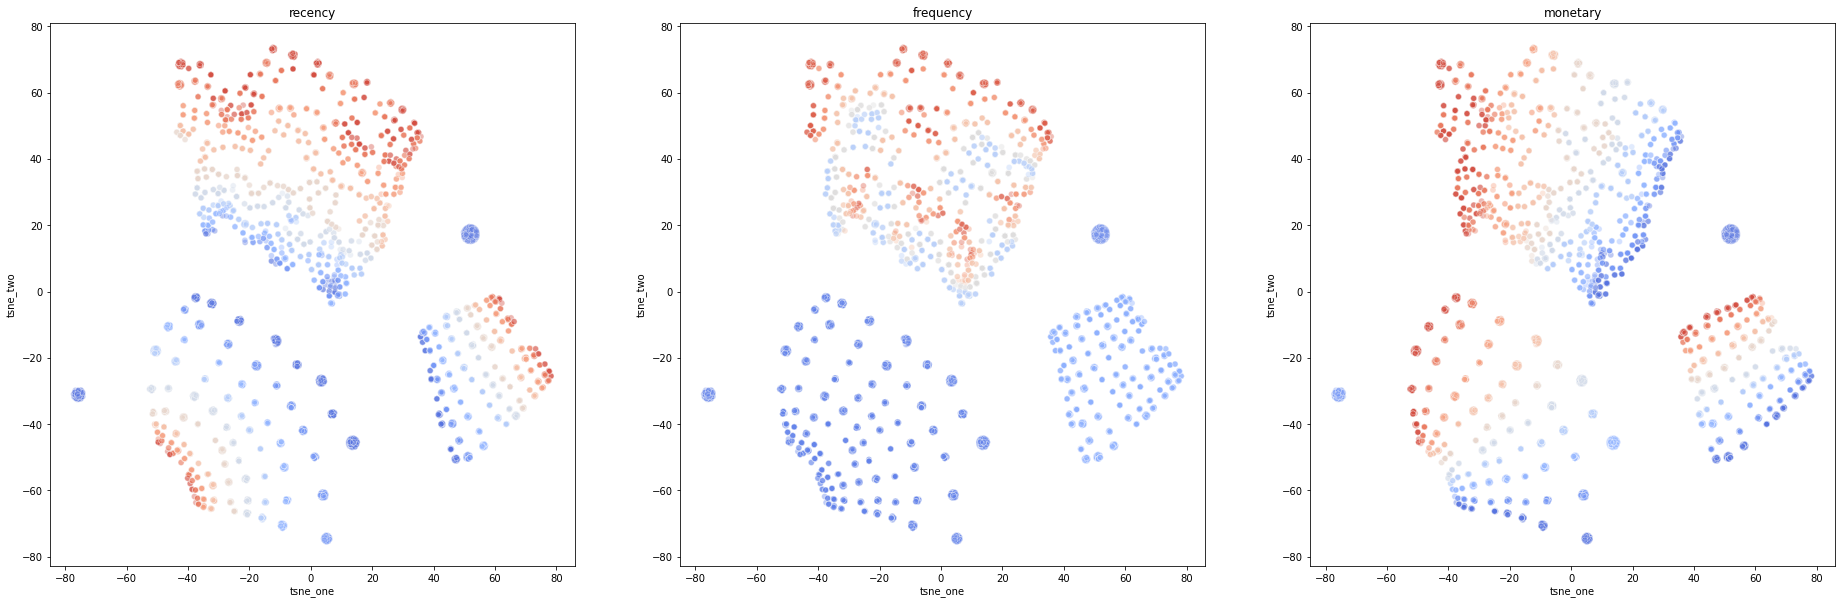

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(32,10))

for i, metric in enumerate(['recency', 'frequency', 'monetary']):
  
  # unique values for this metric
  n = scores_pd[['{0}_score'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}_score'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=scores_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i]
    )

The results of our visual inspection would indicate we have some strong clusters of similar customers in our dataset.  We also have some groups of customers which are similar but vary across the scored dimensions.  With these notions in mind, we can now proceed into the clustering phase of our work.

###Step 5: Cluster Customers Based on RFM Scores

The first step in clustering is to determine the number of clusters we should employ.  With 10 x 10 x 10 theoretical combinations of RFM scores, there are just too many possible segments to deal with. So, let's explore what an ideal number of clusters might be by calculating [silhouette scores](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb) for different cluster arrangements. We'll consider using between 2 and 20 clusters and because clustering with kmeans is stochastic, we'll evaluate each cluster count 5 times.  This will create a lot of processing work so that we'll distribute our hyperparameter values across our Spark cluster using an old-school RDD and broadcast our dataset to each worker in the cluster allowing this work to be performed in an efficient parallelized manner: 

**NOTE** The processing times on this step will drop as you add resources to the cluster (up to 95 worker cores based on 5 * 19 values in the RDD).

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# function to train and score clusters based on k cluster count
def train_model( k ):
  km = KMeans(
    n_clusters=k, 
    init='random',
    n_init=1000
    )
  kmeans = km.fit_predict( inputs_broadcast.value )
  silhouette = silhouette_score( inputs_broadcast.value , kmeans)
  return (k, float(silhouette))

# assemble an rdd containing 5 instances of each k value from 2 to 20
rdd = (
  spark
    .range(2, 21, step=1, numPartitions=sc.defaultParallelism)
    .withColumnRenamed('id','k')
    .crossJoin( spark.range(0, 5) )
    .select('k')
    .rdd
    .map(lambda k: int(k[0]))
  )

# distribute the dataset on which we will perform our evaluation
inputs_pd = scores_pd[['recency_score', 'frequency_score', 'monetary_score']]
inputs_broadcast = sc.broadcast(inputs_pd)

# perform the training/evaluation work
results = rdd.map(train_model)

# release the distributed dataset
inputs_broadcast.unpersist()

# display the results of our analysis
display( spark.createDataFrame( results, schema=['clusters','silhouette']) )

clusters,silhouette
2,0.35673005929395385
2,0.35673005929395385
2,0.35673005929395385
2,0.35673005929395385
2,0.35673005929395385
3,0.3383781314271885
3,0.3383781314271885
3,0.3383781314271885
3,0.3383781314271885
3,0.3383781314271885


From our chart, it appears 8 clusters might be a good target number of clusters.  Let's use that to train our final model:

In [0]:
km = KMeans(
  n_clusters=8, 
  init='random',
  n_init=1000
  )
_ = km.fit( inputs_pd )

Let's now assign each customer to a cluster:

In [0]:
scores_pd['cluster'] = km.predict( inputs_pd )
scores_pd.head()

Out[13]:

,recency_score,frequency_score,monetary_score,tsne_one,tsne_two,cluster
CustomerID,,,,,,
12346,1,1,1,51.530727,15.782519,7
12347,10,9,9,-32.530766,65.387344,3
12348,4,7,9,-33.173378,24.597265,1
12349,8,1,10,-49.917057,-42.430069,4
12350,1,1,7,-11.682281,-14.987722,6


###Step 6: Evaluate Cluster Assignments

Let's now visualize our cluster assignments to see if they provide us anything useful:

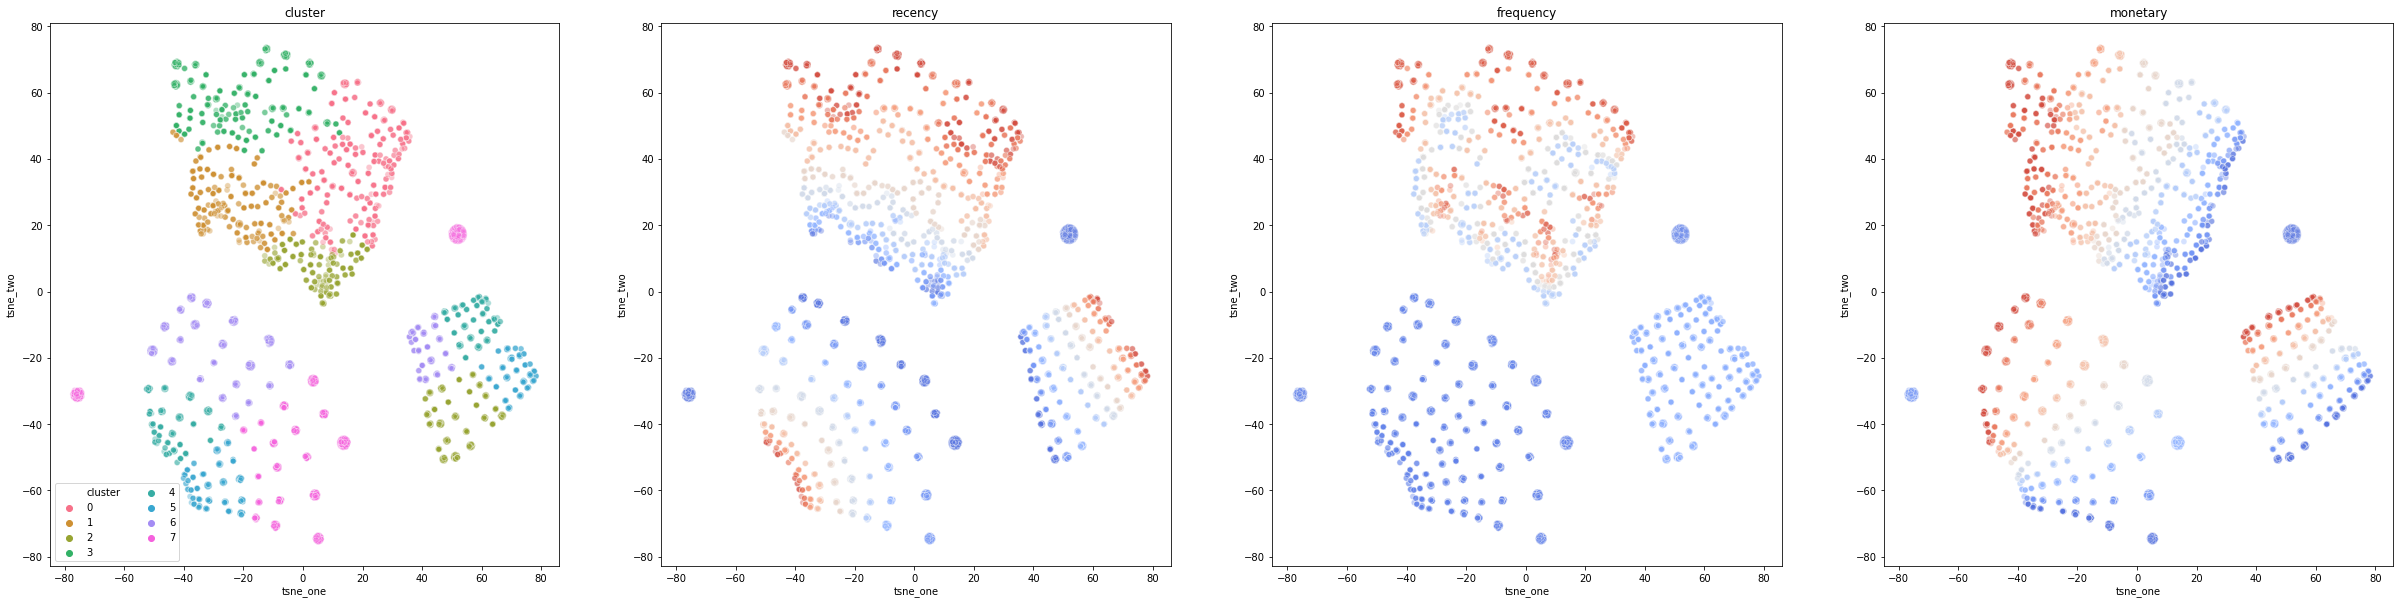

In [0]:
f, axes = plt.subplots(nrows=1, ncols=4, squeeze=True, figsize=(42, 10))

# chart the cluster assignments
axes[0].set_title('cluster')
sns.scatterplot(
  x='tsne_one',
  y='tsne_two',
  hue='cluster',
  palette=sns.color_palette('husl', scores_pd[['cluster']].nunique()[0]),
  data=scores_pd,
  legend='brief',
  alpha=0.4,
  ax = axes[0]
  )
axes[0].legend(loc='lower left', ncol=2, fancybox=True)

# chart the RFM scores
for i, metric in enumerate(['recency', 'frequency', 'monetary']):
  
  # unique values for this metric
  n = scores_pd[['{0}_score'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i+1].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}_score'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=scores_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i+1]
    )

By closely examining the chart, we can start to identify which clusters align with which combinations of RFM scores.  We can also examine the centroids of the clusters to understand how scores align with each:

In [0]:
# generate cluster numbers
clusters = map(lambda c: 'Cluster {}'.format(c), range(0, km.n_clusters))

# extract cluster centroids
metrics = {0:'R', 1:'F', 2:'M'}
centroids = map(lambda scores: ', '.join(['{}: {:.1f}'.format(metrics[i], s) for i,s in enumerate(scores)]) , km.cluster_centers_)

# combine cluster number with centroid info
list(zip(clusters, centroids))


Out[19]: [('Cluster 0', 'R: 7.9, F: 8.1, M: 3.8'),
 ('Cluster 1', 'R: 4.8, F: 7.3, M: 8.0'),
 ('Cluster 2', 'R: 3.2, F: 5.4, M: 2.7'),
 ('Cluster 3', 'R: 8.8, F: 8.8, M: 8.1'),
 ('Cluster 4', 'R: 6.6, F: 2.4, M: 8.0'),
 ('Cluster 5', 'R: 7.1, F: 2.3, M: 2.9'),
 ('Cluster 6', 'R: 2.5, F: 1.9, M: 8.1'),
 ('Cluster 7', 'R: 2.0, F: 1.0, M: 2.7')]